# Opeonimages Object Detection System with GUI

In [ ]:
pip install scikit-image scikit-learn tensorflow utils seaborn

## 1. Preprocessing and Image Enhancement

In [1]:
import cv2
import numpy as np

def preprocess_image(image, target_size=(256, 256)):
    """
    Perform preprocessing and image enhancement.
    Returns original, grayscale, HSV, and binary images for further processing.
    """
    # Resize
    image_resized = cv2.resize(image, target_size)

    # Normalize to [0, 1]
    image_normalized = image_resized.astype(np.float32) / 255.0

    # Convert to grayscale
    gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

    # Denoise using Gaussian blur
    denoised = cv2.GaussianBlur(gray, (5, 5), 0)

    # Contrast enhancement using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast = clahe.apply(denoised)

    # Thresholding using Otsu
    _, binary_otsu = cv2.threshold(contrast, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological operations
    kernel = np.ones((3, 3), np.uint8)
    morph_open = cv2.morphologyEx(binary_otsu, cv2.MORPH_OPEN, kernel, iterations=1)
    morph_close = cv2.morphologyEx(morph_open, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Convert to HSV for possible later use
    hsv = cv2.cvtColor(image_resized, cv2.COLOR_BGR2HSV)

    return {
        "resized": image_resized,
        "normalized": image_normalized,
        "gray": gray,
        "contrast": contrast,
        "binary": morph_close,
        "hsv": hsv
    }


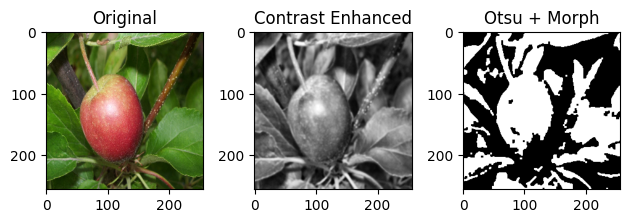

In [2]:
import matplotlib.pyplot as plt

img_path = "E:/Mariam/Uni Studing Material/L4(Second Term)/Computer Vision/project/Object Detection/openimages/apple/images/f765ed1b79eb1f1e.jpg"
image = cv2.imread(img_path)
results = preprocess_image(image)

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(results["resized"], cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title("Contrast Enhanced")
plt.imshow(results["contrast"], cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Otsu + Morph")
plt.imshow(results["binary"], cmap='gray')

plt.tight_layout()
plt.show()


## 2. Segmentation 

In [3]:
import cv2
import numpy as np
# Region Growing Function
def region_growing(img, seed, threshold=5):
    height, width = img.shape
    segmented = np.zeros_like(img)
    visited = np.zeros_like(img, dtype=bool)
    stack = [seed]
    seed_value = img[seed]

    while stack:
        x, y = stack.pop()
        if visited[x, y]:
            continue
        visited[x, y] = True
        if abs(int(img[x, y]) - int(seed_value)) < threshold:
            segmented[x, y] = 255
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < height and 0 <= ny < width:
                        stack.append((nx, ny))
    return segmented


In [4]:
# Watershed Segmentation
def watershed_segmentation(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Morphological cleanup
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    # Background and foreground
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Markers
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # Apply watershed
    img_color = img.copy()
    markers = cv2.watershed(img_color, markers)

    # Draw red boundaries on the original image
    img_color[markers == -1] = [0, 0, 255]

    return img_color



In [5]:
# Watershed Segmentation
def watershed_segmentation2(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Morphological cleanup
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    # Background and foreground
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Markers
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # Apply watershed
    img_color = img.copy()
    markers = cv2.watershed(img_color, markers)

    # Extract binary masks for each object
    masks = []
    for marker_id in np.unique(markers):
        if marker_id <= 1:
            continue  # Skip background/border
        mask = np.uint8(markers == marker_id)
        masks.append(mask)

    return masks  # List of binary masks for each segmented object



In [6]:
# Modular Segmentation Function
import cv2
import numpy as np

def segment_image(image_dict, method="otsu"):
    """
    Segment an image using the selected method.
    - image_dict: output from preprocess_image
    - method: one of ['otsu', 'canny', 'kmeans', 'region_growing', 'watershed']
    """
    if method == "otsu":
        return image_dict["binary"]

    elif method == "canny":
        edges = cv2.Canny(image_dict["gray"], 100, 200)
        return edges

    elif method == "kmeans":
        img = image_dict["resized"]
        Z = img.reshape((-1, 3))
        Z = np.float32(Z)

        # KMeans criteria and clustering
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        K = 3
        _, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Reconstruct clustered image
        centers = np.uint8(centers)
        clustered = centers[labels.flatten()].reshape(img.shape)
        return cv2.cvtColor(clustered, cv2.COLOR_BGR2GRAY)

    elif method == "region_growing":
        seed = (image_dict["gray"].shape[0] // 2, image_dict["gray"].shape[1] // 2)
        return region_growing(image_dict["gray"], seed)

    elif method == "watershed":
        return watershed_segmentation(image_dict["resized"])

    else:
        raise ValueError("Unsupported segmentation method.")



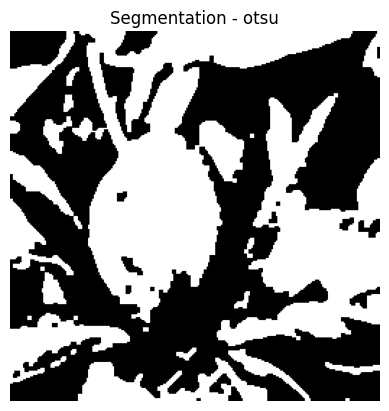

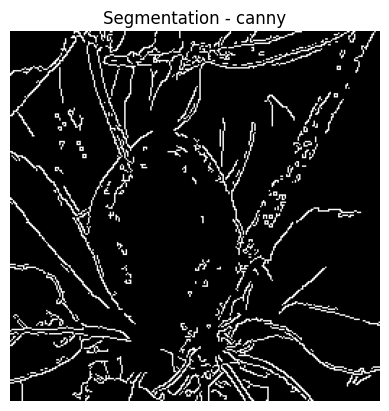

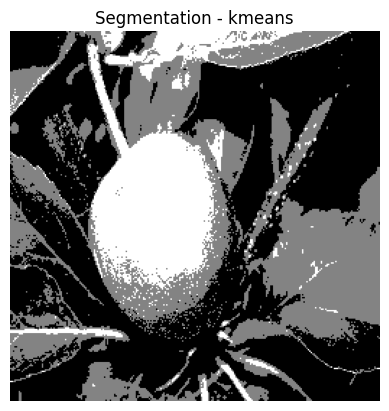

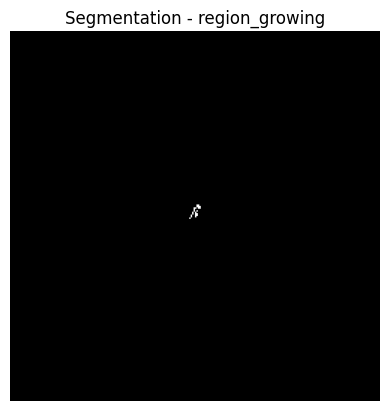

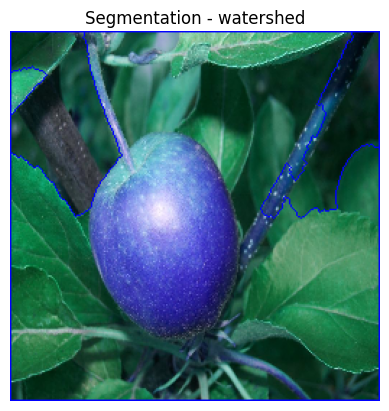

In [7]:
# Testing All Methods on One Image To chose the best one
methods = ["otsu", "canny", "kmeans", "region_growing", "watershed"]
for method in methods:
    segmented = segment_image(results, method)
    plt.imshow(segmented, cmap='gray')
    plt.title(f"Segmentation - {method}")
    plt.axis('off')
    plt.show()


### Based on the output the best way is watershed



## 3. Feature Extraction

    1. Read image and corresponding XML.

    2. Crop each annotated object ROI.

    3. Apply watershed segmentation to the ROI.

    4. Extract features from segmented ROI.

    5. Save feature vector and label.

In [8]:
# Cropping ROIs based on XML bounding boxes
# So that feature extraction is focused only on labeled objects, not the full image.
import xml.etree.ElementTree as ET
import os
import cv2

def parse_pascal_voc(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    objects = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        objects.append((label, xmin, ymin, xmax, ymax))
    return objects


In [9]:
from skimage.feature import local_binary_pattern, hog, graycomatrix, graycoprops
import numpy as np

def extract_features(image):
    if image.shape[0] == 0 or image.shape[1] == 0:
        return np.zeros(150)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    features = []

    # Color Histogram
    for i in range(3):
        hist = cv2.calcHist([hsv], [i], None, [32], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        features.extend(hist)

    # LBP Texture
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    hist_lbp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    hist_lbp = hist_lbp.astype("float")
    hist_lbp /= (hist_lbp.sum() + 1e-6)
    features.extend(hist_lbp)

    # GLCM Texture
    glcm = graycomatrix(gray, [1], [0], symmetric=True, normed=True)
    features.extend([
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'correlation')[0, 0],
        graycoprops(glcm, 'homogeneity')[0, 0],
        graycoprops(glcm, 'ASM')[0, 0],
    ])

    # Shape Features
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        c = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(c)
        perimeter = cv2.arcLength(c, True)
        x, y, w, h = cv2.boundingRect(c)
        aspect_ratio = float(w) / h if h != 0 else 0
        features.extend([area, perimeter, aspect_ratio])
    else:
        features.extend([0, 0, 0])

    return np.array(features)

In [10]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [11]:
def draw_bounding_boxes(img, objects):
    for label, xmin, ymin, xmax, ymax in objects:
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(img, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (36, 255, 12), 2)
    return img

In [12]:
def unified_data_processing_with_bboxes(image_dir, annotation_dir, label_map, target_size=(64, 64)):
    images, features_list, labels, bboxes = [], [], [], []
    for filename in tqdm(os.listdir(image_dir), desc=f"Processing {os.path.basename(image_dir)}"):
        if not filename.lower().endswith(('.jpg', '.png')):
            continue
        image_path = os.path.join(image_dir, filename)
        xml_path = os.path.join(annotation_dir, os.path.splitext(filename)[0] + ".xml")
        if not os.path.exists(xml_path):
            continue
        img = cv2.imread(image_path)
        if img is None:
            continue
        height, width = img.shape[:2]
        objects = parse_pascal_voc(xml_path)
        for label, xmin, ymin, xmax, ymax in objects:
            if label not in label_map:
                continue
            roi = img[ymin:ymax, xmin:xmax]
            if roi.shape[0] == 0 or roi.shape[1] == 0:
                continue
            segmented = watershed_segmentation(roi)
            resized = cv2.resize(segmented, target_size)
            features = extract_features(resized)
            images.append(resized)
            features_list.append(features)
            labels.append(label_map[label])
            bboxes.append([
                xmin / width, ymin / height,
                xmax / width, ymax / height
            ])
    return images, features_list, labels, bboxes

In [13]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(['apple', 'banana', 'car', 'dog', 'person', 'bicycle', 'chair'])
print(encoder.classes_)


['apple' 'banana' 'bicycle' 'car' 'chair' 'dog' 'person']


In [14]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm
from collections import defaultdict
from skimage.feature import local_binary_pattern, hog, graycomatrix, graycoprops
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
def balance_dataset(images, features, labels, bboxes, target_count=1700):
    augmentor = ImageDataGenerator(
        rotation_range=15, width_shift_range=0.1, height_shift_range=0.1,
        zoom_range=0.1, horizontal_flip=True, fill_mode='nearest'
    )
    class_indices = defaultdict(list)
    for idx, label in enumerate(labels):
        class_indices[label].append(idx)

    new_images, new_labels, new_bboxes = [], [], []
    for label, indices in class_indices.items():
        current_count = len(indices)
        if current_count >= target_count:
            selected = np.random.choice(indices, target_count, replace=False)
        else:
            selected = np.random.choice(indices, target_count, replace=True)
        for i in selected:
            img = images[i]
            bbox = bboxes[i]
            label_id = labels[i]
            if img.ndim == 3:
                img = img.reshape((1, *img.shape))
            aug_img = next(augmentor.flow(img, batch_size=1))[0].astype(np.uint8)
            new_images.append(aug_img)
            new_labels.append(label_id)
            new_bboxes.append(bbox)
    return np.array(new_images), np.array(new_labels), np.array(new_bboxes)

def save_images_to_folders(X, y, idx, label_map, out_dir, subset_name):
    inv_map = {v: k for k, v in label_map.items()}
    y_labels = np.argmax(y[:, :len(label_map)], axis=1)
    for i, img in enumerate(X):
        label = inv_map[y_labels[i]]
        path = os.path.join(out_dir, subset_name, label)
        os.makedirs(path, exist_ok=True)
        cv2.imwrite(os.path.join(path, f"{label}_{idx[i]}.jpg"), img)

# ---------- MAIN EXECUTION ---------- #

label_map = {'apple': 0, 'banana': 1, 'bicycle': 2, 'car': 3, 'chair': 4, 'dog': 5, 'person': 6}
categories = list(label_map.keys())
root_dir = r"E:\Mariam\Uni Studing Material\L4(Second Term)\Computer Vision\project\Object Detection\openimages"

images, features, labels, bboxes = [], [], [], []
for category in categories:
    image_dir = os.path.join(root_dir, category, 'images')
    ann_dir = os.path.join(root_dir, category, 'pascal')
    imgs, ftrs, lbls, bxs = unified_data_processing_with_bboxes(image_dir, ann_dir, label_map)
    images.extend(imgs)
    features.extend(ftrs)
    labels.extend(lbls)
    bboxes.extend(bxs)




Processing images: 100%|██████████| 1000/1000 [02:04<00:00,  8.02it/s]


C:\Users\marim\AppData\Local\Temp\ipykernel_12008\582650114.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=np.bincount(labels), palette="viridis")


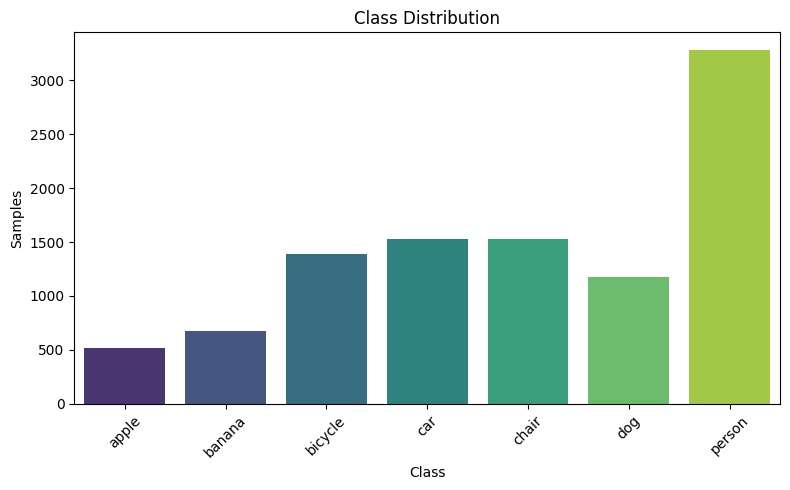

In [16]:
# ----- Label Distribution Before Balancing -----

plt.figure(figsize=(8, 5))
sns.barplot(x=categories, y=np.bincount(labels), palette="viridis")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
images, labels, bboxes = balance_dataset(images, features, labels, bboxes)

In [18]:

# ----- Rebuild One-Hot Encoded Labels After Balancing ----- # 
labels_cat = to_categorical(labels, num_classes=len(label_map))
targets = np.concatenate([labels_cat, bboxes], axis=1)



In [19]:
#assert len(images) == len(labels) == len(bboxes)

Label: 5


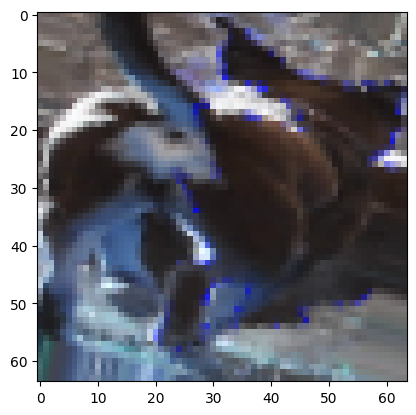

In [20]:
plt.imshow(images[9000])
print("Label:", labels[9000])


C:\Users\marim\AppData\Local\Temp\ipykernel_12008\427753718.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts, palette='viridis')


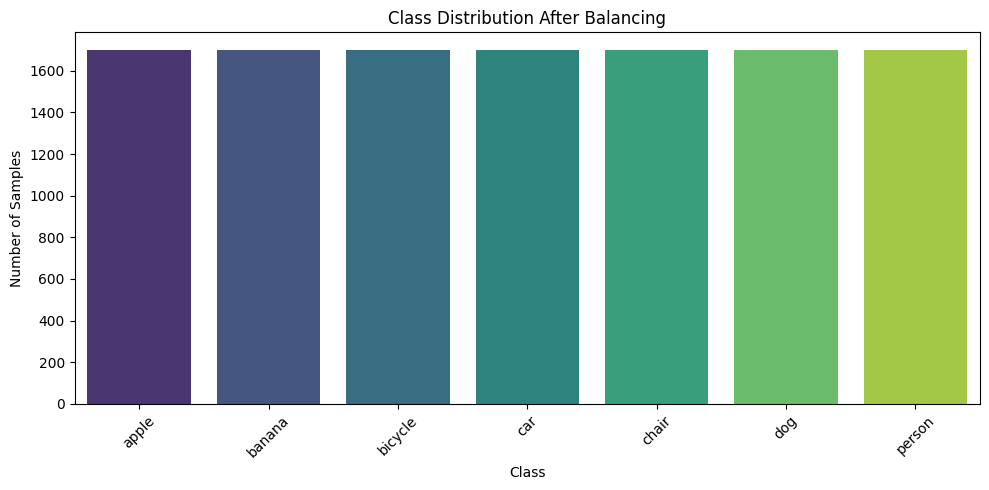

In [21]:
# ----- Label Distribution Plot ----- #
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Count the occurrences of each label
label_counts = Counter(labels)
class_names = [k for k, v in sorted(label_map.items(), key=lambda x: x[1])]
counts = [label_counts[i] for i in range(len(class_names))]

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=class_names, y=counts, palette='viridis')
plt.title("Class Distribution After Balancing")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [22]:
import numpy as np
import os
import cv2
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical



# ----- Train/Test Split for CNN and SVC ----- #

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    images, targets, np.arange(len(images)), test_size=0.2, random_state=42, stratify=labels
)

# ----- Prepare Raw Labels for Saving Images ----- #

labels_array = np.array(labels)
y_train_labels = labels_array[idx_train]
y_test_labels = labels_array[idx_test]

# ----- Flatten the Images for SVC Model ----- #

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# ----- Save Images to Folders (for Visualization) ----- #

def save_images_to_folders(X, y, idx, label_map, out_dir, subset_name):
    inv_map = {v: k for k, v in label_map.items()}
    y_labels = np.argmax(y[:, :len(label_map)], axis=1)
    for i, img in enumerate(X):
        label = inv_map[y_labels[i]]
        path = os.path.join(out_dir, subset_name, label)
        os.makedirs(path, exist_ok=True)
        cv2.imwrite(os.path.join(path, f"{label}_{idx[i]}.jpg"), img)

save_images_to_folders(X_train, y_train, idx_train, label_map, 
                       r"E:\Mariam\Uni Studing Material\L4(Second Term)\Computer Vision\project\Object Detection\train_test_split", "train")
save_images_to_folders(X_test, y_test, idx_test, label_map, 
                       r"E:\Mariam\Uni Studing Material\L4(Second Term)\Computer Vision\project\Object Detection\train_test_split", "test")

In [23]:
# Ensure the number of samples matches for images and labels
print(f"Training samples: {len(X_train)}")
print(f"Training labels: {len(y_train_labels)}")
print(f"Testing samples: {len(X_test)}")
print(f"Testing labels: {len(y_test_labels)}")


Training samples: 9520
Training labels: 9520
Testing samples: 2380
Testing labels: 2380


Image 0 - Label: 2


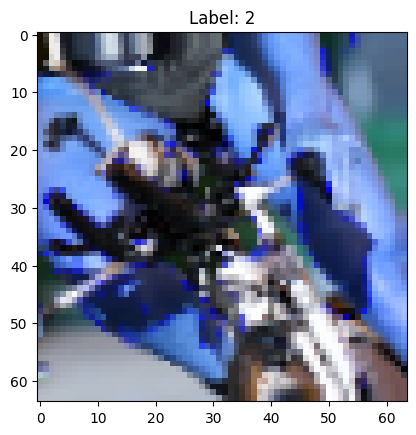

Image 1 - Label: 6


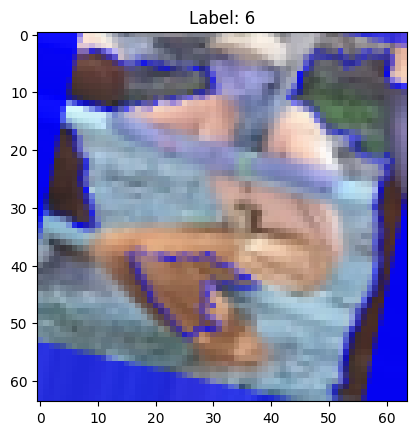

Image 2 - Label: 3


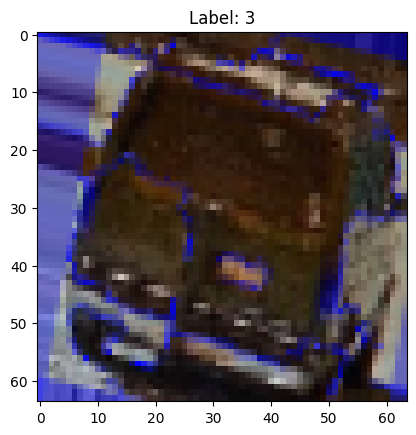

Image 3 - Label: 6


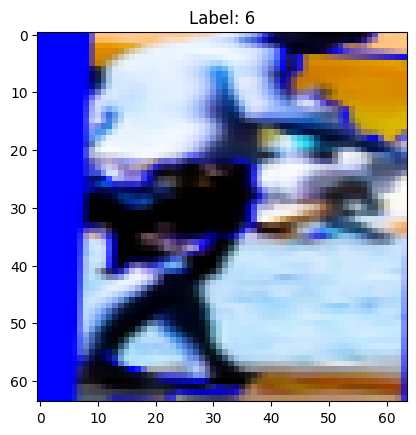

Image 4 - Label: 4


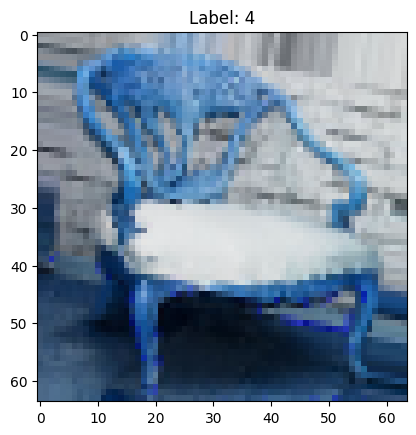

In [24]:
# Check a few samples to ensure correct alignment
for i in range(5):  # Print the first 5 samples
    print(f"Image {i} - Label: {y_train_labels[i]}")
    plt.imshow(X_train[i])  # Display the image
    plt.title(f"Label: {y_train_labels[i]}")
    plt.show()


## 4. Classification 

Techniques:

1. Traditional ML: 
    - Support Vector Classification. (SVC) Takes so much time to run
    - Random Forest

2. Deep Learning:

    - Custom Convolutional Neural Network (CNN)
    - Pretrained MobileNetV2
    - EfficientNetB0

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# ----- SVC Model ----- #
clf = SVC(kernel='rbf', C=1.0, gamma='scale')
clf.fit(X_train_scaled, y_train_labels)

# Evaluate the model on the test data
y_pred_ml = clf.predict(X_test_scaled)

# Print accuracy
accuracy = accuracy_score(y_test_labels, y_pred_ml)
print(f"\nSVC Test Accuracy: {accuracy:.2%}")

# Print classification report
print("\nClassification Report for SVC:")
print(classification_report(y_test_labels, y_pred_ml))

# Plot confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_ml)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title("SVC Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

Test Accuracy: 70.58%

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.70        90
           1       0.74      0.76      0.75       139
           2       0.86      0.80      0.83       317
           3       0.67      0.66      0.66       246
           4       0.68      0.69      0.69       368
           5       0.67      0.65      0.66       248
           6       0.64      0.69      0.66       295

    accuracy                           0.71      1703


In [ ]:
import joblib

# Save the trained model0
joblib.dump(clf, 'svc_classifier.pkl')


Random Forest Test Accuracy: 57.48%

Classification Report for RandomForestC:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       340
           1       0.71      0.74      0.73       340
           2       0.46      0.43      0.44       340
           3       0.60      0.69      0.64       340
           4       0.47      0.40      0.43       340
           5       0.48      0.53      0.51       340
           6       0.46      0.43      0.44       340

    accuracy                           0.57      2380
   macro avg       0.57      0.57      0.57      2380
weighted avg       0.57      0.57      0.57      2380



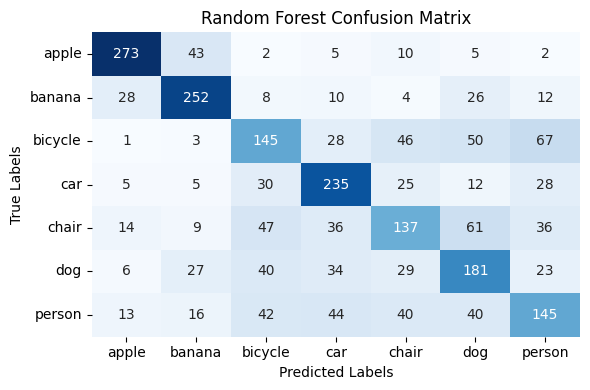

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# ----- RandomForest Model ----- #
clf2 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf2.fit(X_train_scaled, y_train_labels)

# Evaluate the model on the test data
y_pred_ml = clf2.predict(X_test_scaled)

# Print accuracy
accuracy = accuracy_score(y_test_labels, y_pred_ml)
print(f"\nRandom Forest Test Accuracy: {accuracy:.2%}")

# Print classification report
print("\nClassification Report for RandomForestC:")
print(classification_report(y_test_labels, y_pred_ml))

# Plot confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_ml)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()



In [26]:
import joblib

# Save the trained model0
joblib.dump(clf2, 'randomforest_classifier.pkl')

['randomforest_classifier.pkl']

In [27]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical

def create_detector(input_shape=(64, 64, 3), num_classes=7):
    inputs = Input(shape=input_shape)

    # Convolutional Block 1
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, 2)(x)

    # Convolutional Block 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, 2)(x)

    # Convolutional Block 3
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, 2)(x)

    # Convolutional Block 4
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, 2)(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully Connected Layers
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)

    # Outputs
    class_output = Dense(num_classes, activation='softmax', name='class_output')(x)
    bbox_output = Dense(4, activation='sigmoid', name='bbox_output')(x)

    # Model
    model_cnn = Model(inputs, [class_output, bbox_output])
    model_cnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mse'},
        loss_weights={'class_output': 1.0, 'bbox_output': 1.0},
        metrics={'class_output': 'accuracy'}
    )
    return model_cnn


In [28]:
# ----- Split the class and bounding box labels ----- #
y_train_class = y_train[:, :-4]  # Class labels
y_train_bbox = y_train[:, -4:]   # Bounding box labels

y_test_class = y_test[:, :-4]    # Class labels for test
y_test_bbox = y_test[:, -4:]     # Bounding box labels for test




# Learning rate schedule for CNN model
def lr_schedule(epoch, lr):
    if epoch > 10:
        return lr * 0.1
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)



In [29]:
# Create and train CNN model
model_cnn = create_detector(input_shape=(64, 64, 3), num_classes=7)

history = model_cnn.fit(
    X_train,
    {'class_output': y_train_class, 'bbox_output': y_train_bbox},
    validation_split=0.1,
    epochs=15,
    batch_size=32,
    callbacks=[lr_scheduler]
)

Epoch 1/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 69s 216ms/step - bbox_output_loss: 0.0796 - class_output_accuracy: 0.4460 - class_output_loss: 1.5248 - loss: 3.5539 - val_bbox_output_loss: 0.0530 - val_class_output_accuracy: 0.4359 - val_class_output_loss: 1.6317 - val_loss: 2.4646 - learning_rate: 0.0010
Epoch 2/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 51s 191ms/step - bbox_output_loss: 0.0550 - class_output_accuracy: 0.6278 - class_output_loss: 1.0260 - loss: 1.6830 - val_bbox_output_loss: 0.0497 - val_class_output_accuracy: 0.6450 - val_class_output_loss: 0.9941 - val_loss: 1.3225 - learning_rate: 0.0010
Epoch 3/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 75s 280ms/step - bbox_output_loss: 0.0518 - class_output_accuracy: 0.7056 - class_output_loss: 0.8281 - loss: 1.1084 - val_bbox_output_loss: 0.0501 - val_class_output_accuracy: 0.6534 - val_class_output_loss: 1.0091 - val_loss: 1.1981 - learning_rate: 0.0010
Epoch 4/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 61s 228ms/step - bbox_output_loss: 0.0507 - class_output_accura

In [30]:
# Evaluate CNN model
results = model_cnn.evaluate(
    X_test,
    {'class_output': y_test_class, 'bbox_output': y_test_bbox},
    verbose=1
)

# Print CNN evaluation results
total_loss, class_loss, bbox_loss, class_acc = results
print(f"\nCNN Total Loss:         {total_loss:.4f}")
print(f"CNN Class Loss:         {class_loss:.4f}")
print(f"CNN BBox Loss (MSE):    {bbox_loss:.4f}")
print(f"CNN Classification Acc: {class_acc:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - bbox_output_loss: 0.0460 - class_output_accuracy: 0.8552 - class_output_loss: 0.4209 - loss: 0.5592

CNN Total Loss:         0.5548
CNN Class Loss:         0.4204
CNN BBox Loss (MSE):    0.0458
CNN Classification Acc: 0.8588


In [31]:
model_cnn.save("custom_cnn_model.h5")

In [32]:
# Load required libraries for MobileNet and visualization
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


# Split data
X_train, X_test, y_train, y_test = train_test_split(images, labels_cat, test_size=0.2, random_state=42)

# Define MobileNetV2 model
def create_mobilenet_model(input_shape=(64, 64, 3), num_classes=7):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model_mobilenet = Model(inputs=base_model.input, outputs=predictions)

    model_mobilenet.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model_mobilenet

mobilenet_model = create_mobilenet_model(input_shape=(64, 64, 3), num_classes=7)
#mobilenet_model.summary()

# Train model
mobilenet_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

# Evaluate
test_loss, test_acc = mobilenet_model.evaluate(X_test, y_test)
test_acc



C:\Users\marim\AppData\Local\Temp\ipykernel_12008\331159280.py:19: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))


Epoch 1/5


c:\Users\marim\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_18']
Received: inputs=Tensor(shape=(None, 64, 64, 3))
  warnings.warn(msg)


268/268 ━━━━━━━━━━━━━━━━━━━━ 189s 424ms/step - accuracy: 0.6680 - loss: 1.0423 - val_accuracy: 0.3403 - val_loss: 10.6647
Epoch 2/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 91s 340ms/step - accuracy: 0.8592 - loss: 0.4494 - val_accuracy: 0.5021 - val_loss: 7.9697
Epoch 3/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 102s 382ms/step - accuracy: 0.8860 - loss: 0.3612 - val_accuracy: 0.7248 - val_loss: 3.5272
Epoch 4/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 119s 444ms/step - accuracy: 0.9154 - loss: 0.2592 - val_accuracy: 0.7384 - val_loss: 2.7248
Epoch 5/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 96s 359ms/step - accuracy: 0.9117 - loss: 0.2871 - val_accuracy: 0.2237 - val_loss: 17.9066
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.2625 - loss: 17.2288


0.26050421595573425

In [33]:
mobilenet_model.save("mobilenet_model.keras")

In [34]:
# EfficientNetB0

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(images, labels_cat, test_size=0.2, random_state=42)

# Define EfficientNetB0 model
def create_efficientnet_model(input_shape=(64, 64, 3), num_classes=7):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model_efficientnet = Model(inputs=base_model.input, outputs=predictions)

    model_efficientnet.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
    return model_efficientnet

efficientnet_model = create_efficientnet_model(input_shape=(64, 64, 3), num_classes=7)
#efficientnet_model.summary()

# Train model
efficientnet_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

# Evaluate
test_loss, test_acc = efficientnet_model.evaluate(X_test, y_test)
print(f"\nTest Accuracy with EfficientNetB0: {test_acc:.2%}")


Epoch 1/5


c:\Users\marim\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_174']
Received: inputs=Tensor(shape=(None, 64, 64, 3))
  warnings.warn(msg)


268/268 ━━━━━━━━━━━━━━━━━━━━ 285s 659ms/step - accuracy: 0.7295 - loss: 0.7941 - val_accuracy: 0.8666 - val_loss: 0.3774
Epoch 2/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 129s 481ms/step - accuracy: 0.9011 - loss: 0.2926 - val_accuracy: 0.8981 - val_loss: 0.3456
Epoch 3/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 162s 605ms/step - accuracy: 0.9368 - loss: 0.1921 - val_accuracy: 0.8960 - val_loss: 0.3188
Epoch 4/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 175s 651ms/step - accuracy: 0.9536 - loss: 0.1391 - val_accuracy: 0.8887 - val_loss: 0.3654
Epoch 5/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 150s 559ms/step - accuracy: 0.9580 - loss: 0.1267 - val_accuracy: 0.9013 - val_loss: 0.3184
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - accuracy: 0.9056 - loss: 0.3128

Test Accuracy with EfficientNetB0: 90.67%


In [35]:
efficientnet_model.save("EfficientNetB0_model.keras")

In [37]:
# Compare Accuracy

print(f"SVC Accuracy: 70.58 % ")
print(f"Random Forest Accuracy: 57.48 % ")
print(f"Custom CNN Accuracy: 85.88 %")
print(f"MobileNetV2 Accuracy: 26.05 %")
print(f"EfficientNetB0 Accuracy: 90.67 %")

SVC Accuracy: 70.58 % 
Random Forest Accuracy: 57.48 % 
Custom CNN Accuracy: 85.88 %
MobileNetV2 Accuracy: 26.05 %
EfficientNetB0 Accuracy: 90.67 %


### We will use CNN to show example

In [ ]:
# openimages/dog/images/0ae28b5f3d9513a0.jpg
# openimages/person/images/00a01813890455b0.jpg
# openimages/dog/images/0b6304737968e40a.jpg
# openimages/chair/images/0ac256da33db51cc.jpg
# openimages/bicycle/images/00aeae02541ecc2e.jpg
# openimages/car/images/00aaf5c6d57a8670.jpg


Image size: 64x64
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicted classes for the ROIs:
chair


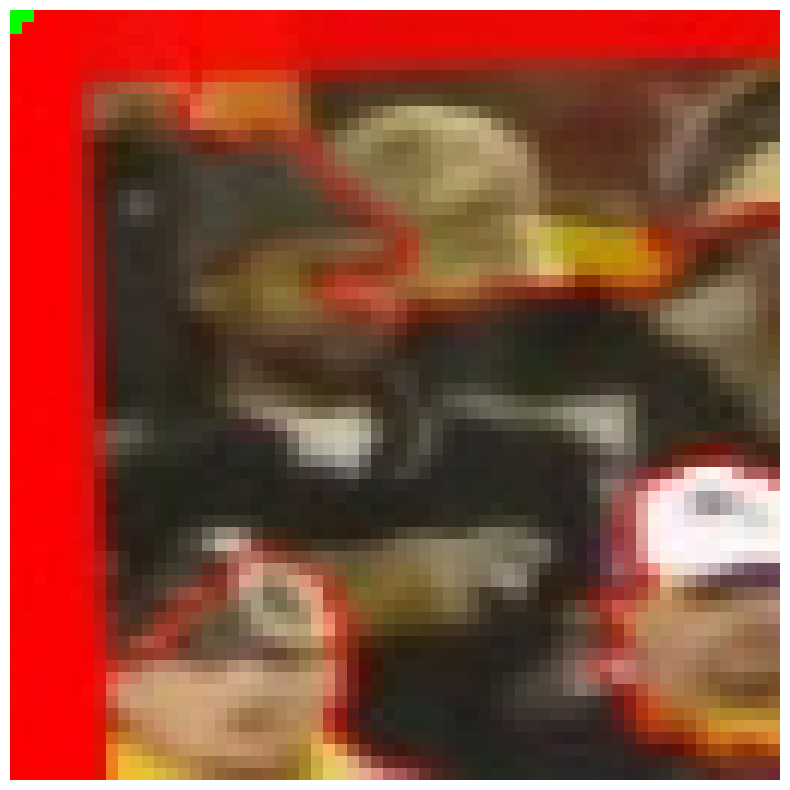

In [39]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError


# Define the custom loss function
mse = MeanSquaredError()

# Load the trained CNN model with the custom loss function
model = load_model("custom_cnn_model.h5", custom_objects={"mse": mse})

# Define the label encoder and your label map
label_map = {'apple': 0, 'banana': 1, 'bicycle': 2, 'car': 3, 'chair': 4, 'dog': 5, 'person': 6}
categories = list(label_map.keys())
encoder = LabelEncoder()
encoder.fit(categories)

# This function scales bounding boxes to the full image size
def scale_bboxes_to_full_image(bboxes, original_size, roi_size=(64, 64)):
    scale_x = original_size[1] / roi_size[1]
    scale_y = original_size[0] / roi_size[0]
    
    scaled_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        x_min_scaled = x_min * scale_x
        y_min_scaled = y_min * scale_y
        x_max_scaled = x_max * scale_x
        y_max_scaled = y_max * scale_y
        scaled_bboxes.append([x_min_scaled, y_min_scaled, x_max_scaled, y_max_scaled])
    
    return scaled_bboxes

# This function extracts features and predicts classes and bounding boxes for the image
def process_image_for_prediction(image_path, model, roi_size=(64, 64)):
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at {image_path} could not be loaded. Check the path.")
    
    height, width = img.shape[:2]
    print(f"Image size: {height}x{width}")  
    
    # If the image is too small for the ROI size, resize it to fit
    if height < roi_size[0] or width < roi_size[1]:
        print("Image is too small for the given ROI size. Resizing the image.")
        img = cv2.resize(img, (max(roi_size[1], width), max(roi_size[0], height)))
        height, width = img.shape[:2]
    
    # Adjust the ROI size if the image is small
    step_size = max(roi_size[0], roi_size[1])  # Ensure step size is at least as large as the ROI size
    
    # Extract ROIs from the image
    rois = []
    bboxes = []
    for y in range(0, height - roi_size[0] + 1, step_size):
        for x in range(0, width - roi_size[1] + 1, step_size):
            roi = img[y:y + roi_size[0], x:x + roi_size[1]]
            rois.append(roi)
            bboxes.append([x, y, x + roi_size[1], y + roi_size[0]])  # The bounding box for this ROI
    
    # Check if any ROIs were extracted
    if len(rois) == 0:
        print("No ROIs extracted. Please check the image and parameters.")
        return None

    # Process each ROI and make predictions
    roi_images = [cv2.resize(roi, roi_size) for roi in rois]
    roi_images = np.array(roi_images)  # Prepare input for the model

    # Ensure the shape is correct: [batch_size, height, width, channels]
    roi_images = roi_images.astype("float32") / 255.0  # Normalize to [0, 1] if needed

    # Predict using the loaded model
    class_preds, bbox_preds = model.predict(roi_images)

    # Decode class predictions (one-hot -> label)
    class_labels = encoder.inverse_transform(np.argmax(class_preds, axis=1))
    
    # Print the predicted classes
    print("Predicted classes for the ROIs:")
    for label in class_labels:
        print(label)
    
    # Scale the bounding boxes to full image size
    scaled_bboxes = scale_bboxes_to_full_image(bbox_preds, original_size=(height, width), roi_size=roi_size)
    
    # Draw the bounding boxes on the original image
    for label, bbox in zip(class_labels, scaled_bboxes):
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
        cv2.putText(img, label, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (36, 255, 12), 2)
    
    # Convert BGR image to RGB for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image with bounding boxes in the same output cell
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide axes
    plt.show()

    return img

# Example usage: Predict objects on a new image
input_image_path = r"E:\Mariam\Uni Studing Material\L4(Second Term)\Computer Vision\project\Object Detection\train_test_split\test\person\person_11848.jpg"  # Replace with your path
processed_image = process_image_for_prediction(input_image_path, model)